In [1]:
import math
import torch
import os
from torchvision.transforms import (
    Compose,
    Resize,
    RandomCrop
)
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    RandomApply,
    InterpolationMode,
    RandomCrop,
    RandomResizedCrop
)
from matplotlib import pyplot as plt
from einops import rearrange
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [5]:
os.makedirs('plexus_train', exist_ok=True)
os.makedirs('plexus_val', exist_ok=True)
os.makedirs('plexus_test', exist_ok=True)
 
 
transform_2x = RandomCrop(size=(512, 512))
data_paths = os.listdir('10x_images_segmentations')
 
train_threshold = 16000
val_threshold = 23000
file_count = 0
for i_path, data_path in enumerate(data_paths):
    torch_obj = torch.load(f'10x_images_segmentations/{data_path}')
    img = torch_obj['img']  # (3, H, W)
    plexus = torch_obj['plexus']  # (1, H, W)s
 
    for _ in range(1_000):
        # 2x transform
        state = torch.get_rng_state()
        img_2x = transform_2x(img).clone()  # (3, H, W)
        torch.set_rng_state(state)
        plexus_2x = transform_2x(plexus).clone()  # (1, H, W)
    

        if file_count < train_threshold:
            folder = 'plexus_train'
        elif file_count < val_threshold:
            folder = 'plexus_val'
        else:
            folder = 'plexus_test'
 
        torch.save(obj={'imgs': img_2x,
                        'plexus_map': plexus_2x},
                   f=f'{folder}/{file_count}_{data_path}')
        file_count += 1
 
print(f'Total files: {file_count}')

Total files: 30000


In [183]:
file_path = 'plexus_train/14001_S15-1518.pt' # 14001_S15-1518
torch_obj = torch.load(file_path)

In [184]:
img_samples = torch_obj['imgs']
plexus_samples = torch_obj['plexus_map']

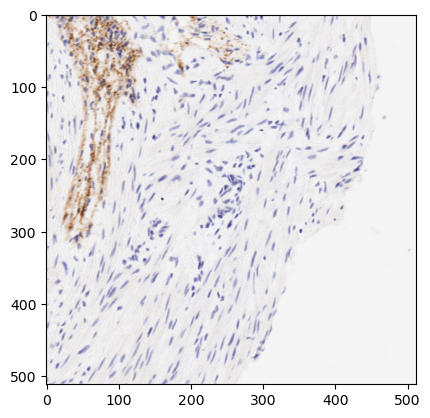

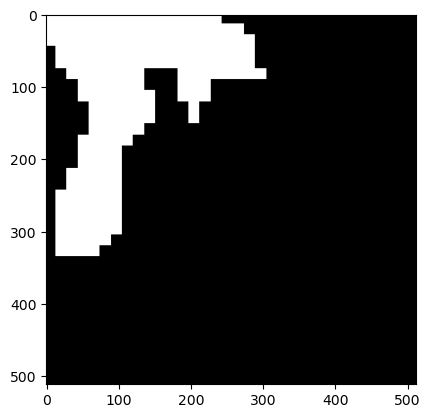

In [185]:
plt.imshow(rearrange(img_samples, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(plexus_samples, 'c h w -> h w c'), cmap='gray')
plt.show()

In [208]:
aug = torch.nn.Sequential(
    RandomRotation((-1, -1)))

In [209]:
def rotatedSqrWithMaxArea(side_outer, angle):

  side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
  #side_inner = round(side_outer / math.sqrt(2))

  return side_inner

In [210]:
side_outer = 512
angle = -1

side_inner = rotatedSqrWithMaxArea(side_outer, angle)

print(f"The dimensions is: {side_inner}")

The dimensions is: 521.1751378282455


In [211]:
state = torch.get_rng_state()
aug_img_samples = aug(img_samples)

torch.set_rng_state(state)
aug_muscle_samples = aug(muscle_samples)

In [212]:
center_x = side_outer // 2
center_y = side_outer // 2

half_width = side_inner // 2
half_height = side_inner // 2 

start_x = round(center_x - half_width)
end_x = round(center_x + half_width)
start_y = round(center_y - half_height)
end_y = round(center_y + half_height)

cropped_imgs = aug_img_samples[:, start_y:end_y, start_x:end_x]
cropped_muscles = aug_muscle_samples[:, start_y:end_y, start_x:end_x]

In [213]:
start_y, end_y, start_x, end_x

(-4, 516, -4, 516)

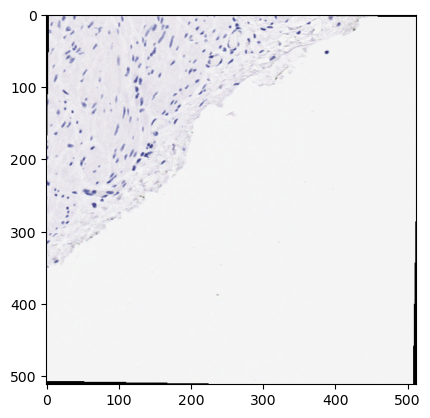

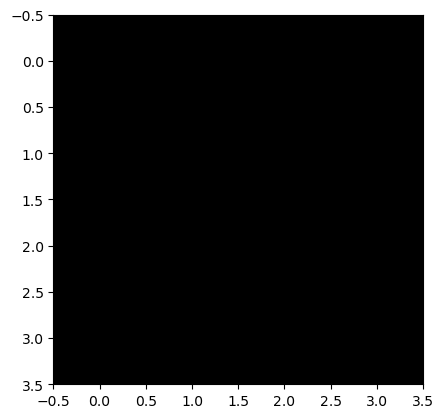

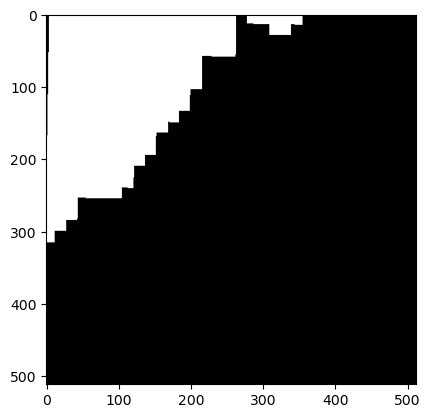

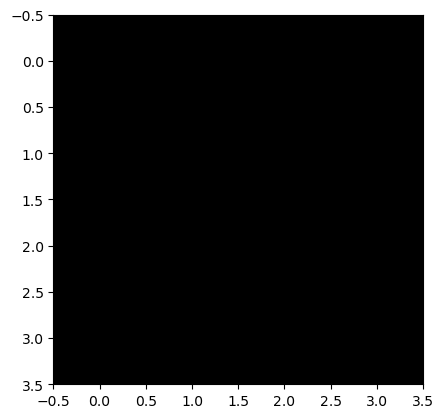

In [214]:
plt.imshow(rearrange(aug_img_samples, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(cropped_imgs, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(aug_muscle_samples, 'c h w -> h w c'), cmap='gray')
plt.show()

plt.imshow(rearrange(cropped_muscles, 'c h w -> h w c'), cmap='gray')
plt.show()

In [312]:
def augment_image_with_map(_img, _map):

    side_outer = 512
    angle = torch.randint(low=0, high=90, size=(1,)).item()
    
    aug1 = torch.nn.Sequential(RandomRotation((angle, angle)))
    
    side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
    print(f"The new h and w are: {side_inner}")
    
    state = torch.get_rng_state()
    _img = aug1(_img)

    torch.set_rng_state(state)
    _map = aug1(_map)
    
    center_x = side_outer // 2
    center_y = side_outer // 2

    half_width = side_inner // 2
    half_height = side_inner // 2 

    start_x = round(center_x - half_width)
    end_x = round(center_x + half_width)
    start_y = round(center_y - half_height)
    end_y = round(center_y + half_height)

    _img = _img[:, start_y:end_y, start_x:end_x]
    _map = _map[:, start_y:end_y, start_x:end_x]
    
    aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0)))
    
    state = torch.get_rng_state()
    _img = aug2(_img)

    torch.set_rng_state(state)
    _map = aug2(_map)
    
    
    return _img, _map

In [313]:
image, mask = augment_image_with_map(img_samples, muscle_samples)

The new h and w are: 503.2929803092663


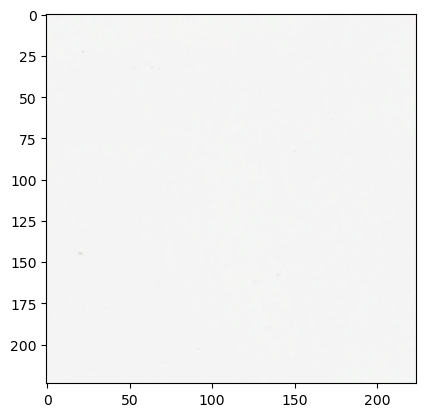

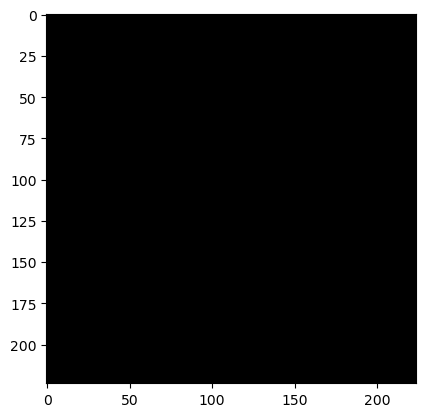

In [297]:
# plt.imshow(rearrange(img_samples, 'c h w -> h w c'))
# plt.show()

plt.imshow(rearrange(image, 'c h w -> h w c'))
plt.show()

# plt.imshow(rearrange(muscle_samples, 'c h w -> h w c'), cmap='gray')
# plt.show()

plt.imshow(rearrange(mask, 'c h w -> h w c'), cmap='gray')
plt.show()

In [86]:
aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0))
)

In [87]:
state = torch.get_rng_state()
aug_img_samples2 = aug2(img_samples)

torch.set_rng_state(state)
aug_muscle_samples2 = aug2(muscle_samples)

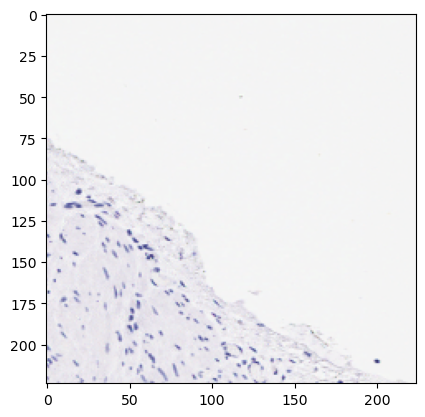

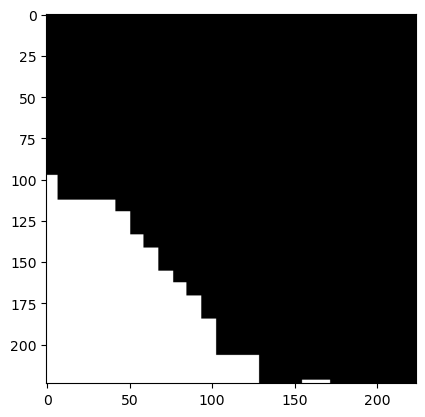

In [88]:
plt.imshow(rearrange(aug_img_samples2, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(aug_muscle_samples2, 'c h w -> h w c'), cmap='gray')
plt.show()


In [283]:
def augment_image_with_map(_img, _map):
    aug1 = torch.nn.Sequential(RandomRotation((45, 45)))
    
    side_outer = 512
    angle = 45
    side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
    print(f"The new h and w are: {side_inner}")
    
    state = torch.get_rng_state()
    _img = aug1(_img)

    torch.set_rng_state(state)
    _map = aug1(_map)
    
    center_x = side_outer // 2
    center_y = side_outer // 2

    half_width = side_inner // 2
    half_height = side_inner // 2 

    start_x = round(center_x - half_width)
    end_x = round(center_x + half_width)
    start_y = round(center_y - half_height)
    end_y = round(center_y + half_height)

    _img = _img[:, start_y:end_y, start_x:end_x]
    _map = _map[:, start_y:end_y, start_x:end_x]
    
    aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5))
    #RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0)))
    
    state = torch.get_rng_state()
    _img = aug2(_img)

    torch.set_rng_state(state)
    _map = aug2(_map)
    
    
    return _img, _map

In [281]:
image, plexus = augment_image_with_map(img_samples, muscle_samples)

The new h and w are: 362.03867196751236


In [285]:
side_outer = 512
angle = 0
side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
print(f"The new h and w are: {side_inner}")



center_x = side_outer // 2
center_y = side_outer // 2
print(center_x)

half_width = side_inner // 2
half_height = side_inner // 2 
print(half_width)

start_x = round(center_x - half_width)
print(start_x)
end_x = round(center_x + half_width)
print(end_x)
start_y = round(center_y - half_height)
end_y = round(center_y + half_height)

The new h and w are: 512.0
256
256.0
0
512


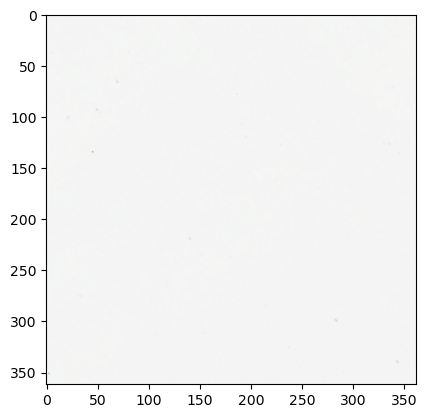

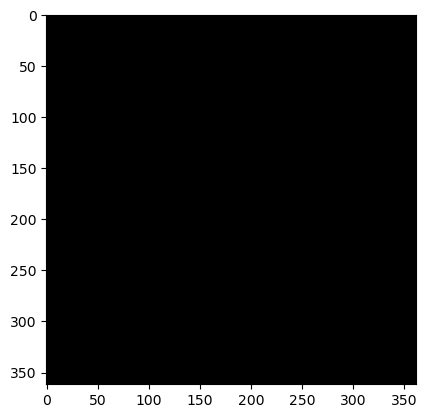

In [284]:
plt.imshow(rearrange(image, 'c h w -> h w c'))
plt.show()

plt.imshow(rearrange(plexus, 'c h w -> h w c'), cmap='gray')
plt.show()